# Meta-RL-Based Deep Brain Stimulation Study

Neurological disorders, such as Parkinson’s disease, are closely tied to abnormal neuronal synchronization, which manifests as symptoms like tremors and rigidity. Current treatments, such as deep brain stimulation (DBS), often rely on open-loop systems with fixed stimulation patterns. While effective to some extent, these systems lack adaptability, making it challenging to address the dynamic and nonlinear nature of neuronal synchronization.  

This project aims to revolutionize DBS systems by integrating **meta-reinforcement learning (meta-RL)** agents capable of real-time adaptation. The proposed system dynamically adjusts stimulation intensity to suppress pathological neuronal synchronization more efficiently. Unlike traditional DBS methods, which require manual tuning by clinicians and fail to account for individual and temporal variability, a meta-RL approach can learn from diverse neural activity patterns and adapt quickly to new or evolving brain states.  

The use of reinforcement learning (RL) introduces a **data-driven optimization strategy** that does not require explicit knowledge of the underlying neural models. By focusing on meta-RL, this project emphasizes cross-task learning, enabling the agent to generalize its control strategies across a variety of neural synchronization scenarios. This adaptability is critical for tailoring stimulation to the unique and changing requirements of individual patients, improving both therapeutic outcomes and quality of life.  

In essence, this project bridges advanced machine learning techniques with neuroengineering to create a smarter, more personalized, and adaptive neuromodulation framework.

## Senario 1
### 1. Project importing and environment preparation  
These libraries are used for environment simulation, neural network implementation, and visualization.  


In [108]:
!pip install gymnasium numpy torch matplotlib
!pip install gym
!pip install stable-baselines3[extra] 



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python3.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python3.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python3.exe -m pip install --upgrade pip


In [109]:
# Import necessary libraries
import numpy as np                # Numerical computation
import matplotlib.pyplot as plt   # Visualization
import torch                      # PyTorch for deep learning
import torch.nn as nn             # Neural network modules
import torch.optim as optim       # Optimization algorithms
from gymnasium import Env         # Base class for custom environments
from gymnasium.spaces import Box  # Continuous action and observation spaces
import gym
from gym import spaces


### 2. Define task environment (oscillator_env.py)  
 Define a custom environment that simulates brain oscillatory behavior. The agent will interact with this environment to minimize oscillations and stabilize the system by applying control actions.  
 

In [110]:
# Oscillator Environment
class OscillatorTaskEnv(Env):
    def __init__(self, damping=0.5, frequency=1.0, task_id=0):
        self.damping = damping  # 阻尼系数
        self.frequency = frequency  # 振荡频率
        self.task_id = task_id  # 任务 ID
        
        # Define observation and action spaces
        self.observation_space = Box(low=-1.0, high=1.0, shape=(1,), dtype=np.float32)
        self.action_space = Box(low=-1.0, high=1.0, shape=(1,), dtype=np.float32)
        
        self.state = 0.0
        self.time = 0.0
    
    def reset(self, seed=None, **kwargs):
        self.state = np.random.uniform(-0.1, 0.1)  # Initialize state
        self.time = 0.0
        return np.array([self.state], dtype=np.float32), {}
    
    def step(self, action):
        voltage = action[0]
        self.state += -self.damping * self.state + self.frequency * np.sin(self.time) + voltage
        self.time += 0.1

        # 新的奖励函数设计：增加对振幅和控制信号的惩罚
        reward = -abs(self.state) - 0.1 * abs(voltage) - 0.05 * (voltage**2)  # Minimize oscillation and energy
        terminated = self.time >= 10000  # Simulation ends at 10000 seconds
        truncated = False  # For simplicity, let's assume `truncated` is always False
        info = {}  # Optional additional information

        # 返回 5 个值
        return np.array([self.state], dtype=np.float32), reward, terminated, truncated, info

    def render(self):
        print(f"Time: {self.time:.2f}, State: {self.state:.2f}")



### 3. Define Meta-RL agent (meta_rl_agent.py)  
Define the Meta-RL Agent that uses an LSTM-based architecture. This agent learns to stabilize the oscillator across multiple tasks.

In [111]:
# Meta-RL Agent with LSTM
class MetaRLAgent(nn.Module):
    def __init__(self, input_dim, action_dim, hidden_dim=128):
        super(MetaRLAgent, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, action_dim)
    
    def forward(self, obs, hidden_state):
        lstm_out, hidden_state = self.lstm(obs.unsqueeze(0), hidden_state)
        action = self.fc(lstm_out[:, -1, :])  # Take the last time step output
        return action, hidden_state

# Function to create an agent and optimizer
def create_agent(input_dim=1, action_dim=1, hidden_dim=128, lr=0.0005):
    agent = MetaRLAgent(input_dim, action_dim, hidden_dim)
    optimizer = optim.Adam(agent.parameters(), lr=1e-4) # 将学习率降低,避免过学习
    return agent, optimizer


### 4. Train the agent (train_meta_rl.py)

In [112]:
def train_meta_rl_agent(agent, optimizer, environments, num_iterations=10000, max_steps=100):
    episode_rewards = []  # 用于存储每个 episode 的奖励
    hidden_dim = 128  # 隐藏状态的维度

    all_iterations_actions = []  # 记录每个迭代的控制信号
    all_iterations_states = []  # 记录每个迭代的状态

    for iteration in range(num_iterations):
        total_loss = 0
        episode_reward = 0  # 累积奖励初始化为0
        all_actions = []  # 存储所有控制信号
        all_states = []  # 存储所有状态

        for env in environments:
            obs = env.reset()  # 获取初始状态

            # 如果 obs 是元组，提取第一个元素
            if isinstance(obs, tuple):
                obs = obs[0]  # 提取第一个元素作为状态

            # 如果 obs 是 numpy 数组，转换为 Tensor
            if isinstance(obs, np.ndarray):
                obs = torch.tensor(obs, dtype=torch.float32)
            elif isinstance(obs, torch.Tensor):
                obs = obs.float()  # 确保 obs 是 float 类型的 Tensor

            hidden_state = (torch.zeros(1, 1, hidden_dim), torch.zeros(1, 1, hidden_dim))
            episodic_loss = torch.tensor(0.0, requires_grad=True)

            for step in range(max_steps):
                obs_tensor = obs.unsqueeze(0)  # 增加一个维度，变为 (1, 1, hidden_dim)

                # 代理根据状态选择动作
                action_tensor, hidden_state = agent(obs_tensor, hidden_state)
                action = action_tensor.detach().numpy()[0]

                action_tensor = torch.tensor(action, dtype=torch.float32)
                action_tensor = torch.clip(action_tensor, min=-1.0, max=1.0)

                # 环境执行动作，返回下一个状态和奖励
                obs, reward, terminated, truncated, info = env.step(action_tensor.numpy())
                obs = torch.tensor(obs, dtype=torch.float32)

                # 确保奖励在合理范围内
                reward = np.clip(reward, -100, 100)

                # 累加奖励
                episodic_loss = episodic_loss + (-reward + torch.mean(torch.abs(action_tensor)))  # 直接累加奖励

                # 输出调试信息
                print(f"Step {step}, Reward: {reward}, Loss: {episodic_loss.item()}")

                if torch.isnan(episodic_loss) or torch.isinf(episodic_loss):
                    print(f"NaN or Inf detected in episodic_loss at step {step}")
                    break

                episode_reward += reward

                # 记录状态
                all_states.append(obs.numpy())  # 将状态保存为 numpy 数组
                all_actions.append(action)

                if terminated or truncated:
                    break

            # 反向传播，更新代理
            optimizer.zero_grad()
            episodic_loss.backward()
            torch.nn.utils.clip_grad_norm_(agent.parameters(), max_norm=0.5)  # 更小的梯度裁剪值
            optimizer.step()
            total_loss += episodic_loss.item()

        all_iterations_actions.append(np.mean(all_actions, axis=0))
        all_iterations_states.append(np.mean(all_states, axis=0))  # 记录每个迭代的平均状态

        episode_rewards.append(episode_reward)

        for param_group in optimizer.param_groups:
            param_group['lr'] *= 0.99

        if iteration % 100 == 0:
            print(f"Iteration {iteration}, Reward: {episode_reward}, Loss: {total_loss / len(environments):.4f}")

    return episode_rewards, all_iterations_actions, all_iterations_states


### 5. Test agent (test_meta_rl.py)

In [113]:
def evaluate_final_performance(agent, env, steps=10000):
    # 重置环境，获取初始状态
    obs = env.reset()
    
    # 如果 `obs` 是元组（例如包含状态和信息），提取状态部分
    if isinstance(obs, tuple):
        obs = obs[0]
    
    # 初始化隐藏状态和奖励
    hidden_state = (torch.zeros(1, 1, 128), torch.zeros(1, 1, 128))
    total_reward = 0
    states = []  # 用于存储状态
    actions = []  # 用于存储动作

    for _ in range(steps):
        # 将 `obs` 转换为 PyTorch tensor，并添加一个维度
        obs_tensor = torch.tensor(obs, dtype=torch.float32).unsqueeze(0)

        # 使用代理预测动作
        action_tensor, hidden_state = agent(obs_tensor, hidden_state)
        action = action_tensor.detach().numpy()[0]

        # 执行动作，获取新状态、奖励等信息
        obs, reward, terminated, truncated, info = env.step(action)

        # 存储状态和动作
        states.append(obs)
        actions.append(action)

        # 累加奖励
        total_reward += reward

        # 如果到达终止条件，退出循环
        if terminated or truncated:
            break

    return total_reward, states, actions



### 6. Visualization learning speed, final reward and model output (test_meta_rl.py)

In [114]:
# Visualize results
def plot_results(episode_rewards, final_reward, states, actions):
    """
    Plot the training progress and testing outcomes.
    Args:
    - episode_rewards: List of rewards per training episode.
    - final_reward: Total reward achieved in the test environment.
    - states: Observed states during testing.
    - actions: Actions taken during testing.
    """
    # Plot learning speed
    plt.figure(figsize=(12, 10))

    # Learning speed
    plt.subplot(2, 2, 1)
    plt.plot(episode_rewards, label="Episode Rewards")
    plt.title("Learning Speed")
    plt.xlabel("Episodes")
    plt.ylabel("Reward")
    plt.grid(True)

    # Final reward
    plt.subplot(2, 2, 2)
    plt.bar(["Final Reward"], [final_reward])
    plt.title("Final Reward")
    plt.ylabel("Reward")

    # State dynamics
    plt.subplot(2, 2, 3)
    plt.plot(states, label="State Dynamics")
    plt.title("State Dynamics Over Time")
    plt.xlabel("Time Steps")
    plt.ylabel("State")

    # Control actions
    plt.subplot(2, 2, 4)
    plt.plot(actions, label="Control Action", color="red")
    plt.title("Control Actions Over Time")
    plt.xlabel("Time Steps")
    plt.ylabel("Action (Voltage)")
    plt.grid(True)

    plt.tight_layout()
    plt.show()



### 7. Summary and visulization

Step 0, Reward: -0.010122980692267374, Loss: 0.026395101100206375
Step 1, Reward: -0.11119860405435154, Loss: 0.14637990295886993
Step 2, Reward: -0.22598270563703154, Loss: 0.37713444232940674
Step 3, Reward: -0.34321970982467015, Loss: 0.7227162718772888
Step 4, Reward: -0.4588517238688627, Loss: 1.182328701019287
Step 5, Reward: -0.5708267717141947, Loss: 1.7535486221313477
Step 6, Reward: -0.6776489467020487, Loss: 2.43247652053833
Step 7, Reward: -0.7779261493441539, Loss: 3.212398052215576
Step 8, Reward: -0.8705609055844141, Loss: 4.085559844970703
Step 9, Reward: -0.9545702268715733, Loss: 5.04326057434082
Step 10, Reward: -1.0290792395500412, Loss: 6.075943946838379
Step 11, Reward: -1.0933216397747345, Loss: 7.173299312591553
Step 12, Reward: -1.1466425507302727, Loss: 8.324365615844727
Step 13, Reward: -1.1885018684523136, Loss: 9.5176420211792
Step 14, Reward: -1.2184775051513088, Loss: 10.741206169128418
Step 15, Reward: -1.2362681935365631, Loss: 11.982831954956055
Step 1

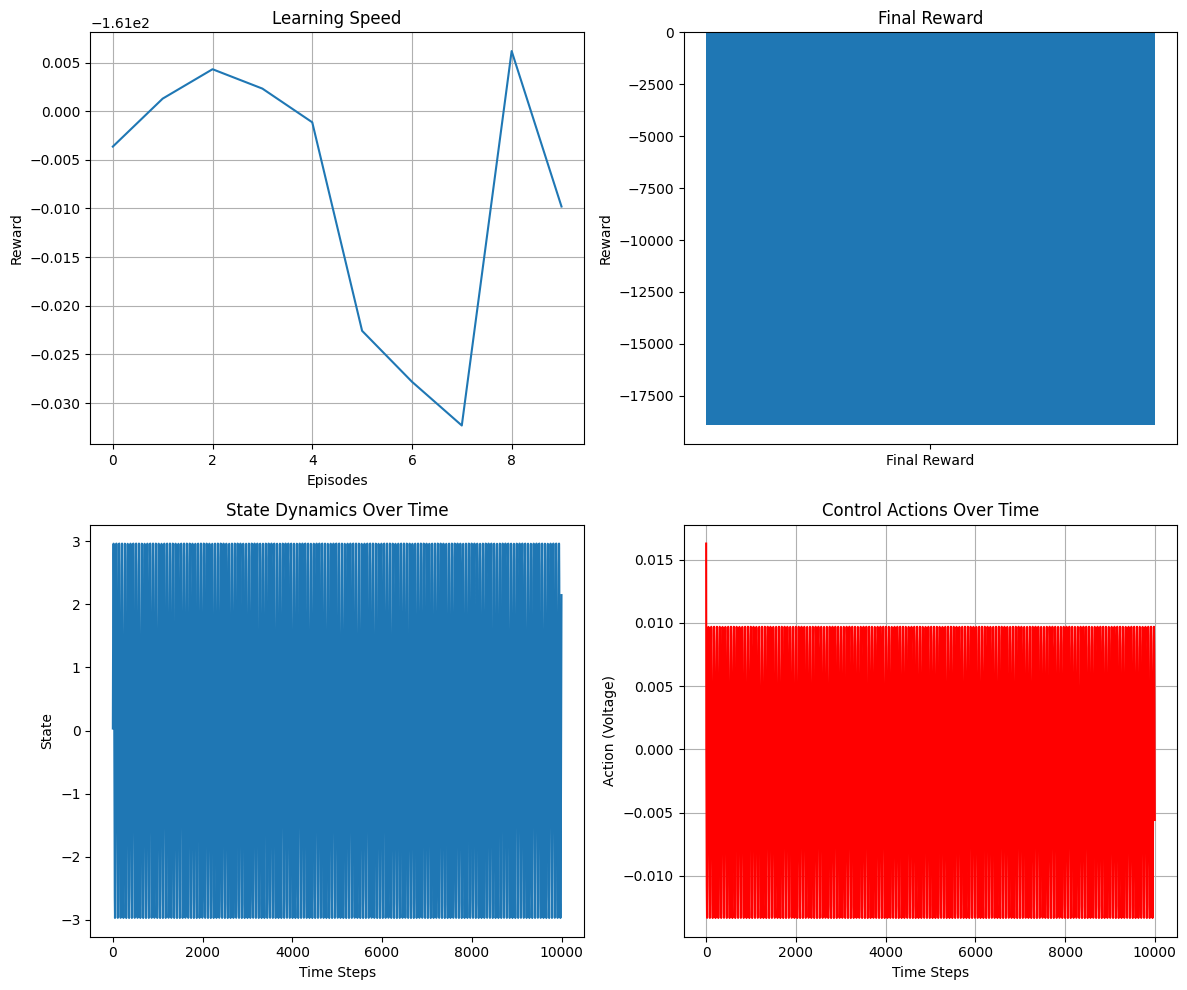

In [115]:
# Create environments
tasks = [
    {"damping": 0.8, "frequency": 1.0},
    {"damping": 0.9, "frequency": 0.8},
    {"damping": 1.0, "frequency": 0.5},
]

environments = [OscillatorTaskEnv(**task, task_id=i) for i, task in enumerate(tasks)]

# Initialize agent and optimizer
agent, optimizer = create_agent()

# 获取控制信号和神经元放电状态
episode_rewards, all_iterations_actions, all_iterations_states = train_meta_rl_agent(agent, optimizer, environments, num_iterations=10)

# Test the agent
test_env = OscillatorTaskEnv(damping=0.6, frequency=1.8)
final_reward, states, actions = evaluate_final_performance(agent, test_env)

# Plot the results
plot_results(episode_rewards, final_reward, states, actions)

Shape of all_iterations_states: (10, 1)
Shape of all_iterations_actions: (10, 1)
[array([-0.00127007], dtype=float32), array([-0.0012723], dtype=float32), array([-0.0012694], dtype=float32), array([-0.00126899], dtype=float32), array([-0.00126952], dtype=float32), array([-0.00127309], dtype=float32), array([-0.0012729], dtype=float32), array([-0.00127242], dtype=float32), array([-0.00127024], dtype=float32), array([-0.00127161], dtype=float32)]


<Figure size 1200x600 with 0 Axes>

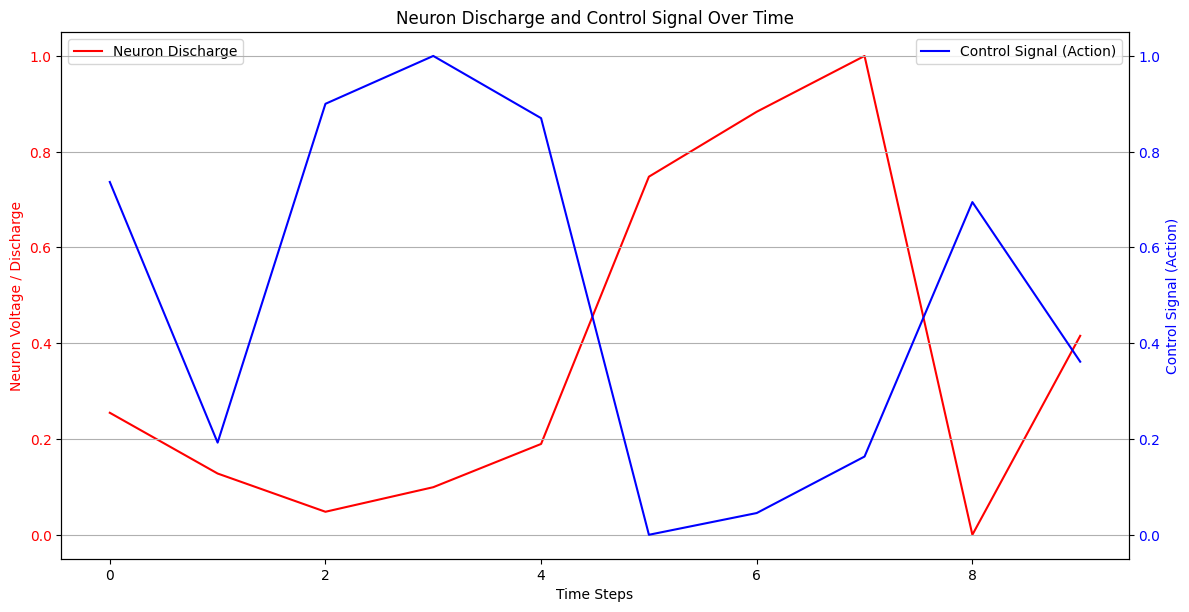

In [116]:
# # # 查看 all_iterations_states 的形状
print("Shape of all_iterations_states:", np.shape(all_iterations_states))
print("Shape of all_iterations_actions:", np.shape(all_iterations_actions))
print(f"{all_iterations_actions}")

# 数据归一化函数 (Min-Max Scaling)
def normalize(data):
    min_val = np.min(data)
    max_val = np.max(data)
    return (data - min_val) / (max_val - min_val)

# 对神经元状态和控制信号进行归一化
normalized_states = normalize(all_iterations_states)
normalized_actions = normalize(all_iterations_actions)

# 绘制对比图
plt.figure(figsize=(12, 6))

# 创建双 y 轴图
fig, ax1 = plt.subplots(figsize=(12, 6))

# 绘制神经元放电状态（归一化后的数据）
ax1.plot(normalized_states[:], label="Neuron Discharge", color='r')
ax1.set_xlabel("Time Steps")
ax1.set_ylabel("Neuron Voltage / Discharge", color='r')
ax1.tick_params(axis='y', labelcolor='r')

# 创建第二个 y 轴，用于控制信号
ax2 = ax1.twinx()  
ax2.plot(normalized_actions[:], label="Control Signal (Action)", color='b')
ax2.set_ylabel("Control Signal (Action)", color='b')
ax2.tick_params(axis='y', labelcolor='b')

# 添加图例和标题
fig.tight_layout()
ax1.legend(loc="upper left")
ax2.legend(loc="upper right")
plt.title(f"Neuron Discharge and Control Signal Over Time")
plt.grid(True)
plt.show()


In [117]:
# 模拟控制前的神经元状态（没有控制）
def get_neural_state_before_control(env, steps=10000):
    obs = env.reset()  # 获取初始状态
    states = []

    for _ in range(steps):
        # 如果 obs 是元组，只获取第一个元素（即状态）
        if isinstance(obs, tuple):
            obs = obs[0]
        
        # 确保 obs 是 numpy 数组并且形状一致
        obs = np.array(obs, dtype=np.float32)  # 确保 obs 是 numpy 数组
        states.append(obs)  # 添加到 states 列表中
        action = np.random.uniform(-1, 1, size=(1,))  
        obs, _, terminated, _, _ = env.step(action)  
        if terminated:
            break
    # print(f"Generated {len(states)} states before control.")  # 打印状态数量
    # 返回一个包含所有状态的二维 NumPy 数组
    return np.array(states)


# 模拟控制后的神经元状态（使用训练后的Meta-RL控制）
def get_neural_state_after_control(agent, env, steps=10000):
    obs = env.reset()  # 获取初始状态
    hidden_state = (torch.zeros(1, 1, 128), torch.zeros(1, 1, 128))
    states = []

    for _ in range(steps):
        # 如果 obs 是元组，只获取第一个元素（即状态）
        if isinstance(obs, tuple):
            obs = obs[0]
        
        states.append(obs)  # 确保将每个状态添加到 states 列表中
        obs_tensor = torch.tensor(obs, dtype=torch.float32).unsqueeze(0)
        action_tensor, hidden_state = agent(obs_tensor, hidden_state)  # 使用代理控制
        action = action_tensor.detach().numpy()[0]
        obs, _, terminated, _, _ = env.step(action)  # 执行一步
        if terminated:
            break
    # print(f"Generated {len(states)} states after control.")  # 打印状态数量
    # 将 states 转换为 NumPy 数组
    return np.array(states)


### 8. PPO Training and Testing

In [118]:
from stable_baselines3 import PPO
from stable_baselines3.common.env_util import make_vec_env

# 环境和代理初始化
tasks = [
    {"damping": 0.3, "frequency": 1.0},
    {"damping": 0.5, "frequency": 1.5},
    {"damping": 0.8, "frequency": 2.0},
]
environments = [OscillatorTaskEnv(**task, task_id=i) for i, task in enumerate(tasks)]
agent, meta_rl_optimizer = create_agent(input_dim=1, action_dim=1, hidden_dim=128)
env = make_vec_env(lambda: environments[0], n_envs=1)  # 使用第一个任务

# 创建 PPO 模型
model = PPO("MlpPolicy", env, verbose=1)

# 训练模型
model.learn(total_timesteps=10000, progress_bar=False )

# # 保存模型
model.save("ppo_oscillator")

# 加载模型
model = PPO.load("ppo_oscillator")

# 获取优化器
ppo_optimizer = model.policy.optimizer

# 测试 PPO 控制效果
obs = env.reset()
states = []

for _ in range(10000):
    action, _ = model.predict(obs)
    obs, _, done, _ = env.step(action)
    ppo_states.append(obs[0])  # 记录状态（神经元放电）
    ppo_actions.append(action[0])  # 记录控制信号
    if done:
        break

# 比较 PPO 和 Meta-RL 的控制效果
steps = 10000
before_control = get_neural_state_before_control(environments[0], steps)
meta_rl_states = get_neural_state_after_control(agent, environments[0], steps)
ppo_states = states  # 从 PPO 的测试阶段获取

# 绘制对比图
plt.figure(figsize=(12, 8))

# 绘制控制前的神经元放电
plt.subplot(3, 1, 1)
plt.plot(before_control[:10000], label="Neuron Discharge with Tremor (Before Control)", color='r')
plt.title("Neuron Discharge with Tremor Pattern (Before Control)")
plt.xlabel("Time (s)")
plt.ylabel("Neuron Voltage / Discharge")
plt.grid(True)
plt.legend()

# Meta-RL 控制
plt.subplot(3, 1, 2)
plt.plot(meta_rl_states[:10000], label="Meta-RL Control", color='g')
plt.title("Neuron Discharge Under Meta-RL Control")
plt.xlabel("Time Steps")
plt.ylabel("Neuron Voltage / Discharge")
plt.legend()
plt.grid(True)

# PPO 控制
plt.subplot(3, 1, 3)
plt.plot(ppo_states[:10000], label="PPO Control", color='b')
plt.title("Neuron Discharge Under PPO Control")
plt.xlabel("Time Steps")
plt.ylabel("Neuron Voltage / Discharge")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

Using cpu device
-----------------------------
| time/              |      |
|    fps             | 287  |
|    iterations      | 1    |
|    time_elapsed    | 7    |
|    total_timesteps | 2048 |
-----------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 177         |
|    iterations           | 2           |
|    time_elapsed         | 23          |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.012982766 |
|    clip_fraction        | 0.184       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.41       |
|    explained_variance   | 0.00242     |
|    learning_rate        | 0.0003      |
|    loss                 | 507         |
|    n_updates            | 10          |
|    policy_gradient_loss | -0.0248     |
|    std                  | 0.987       |
|    value_loss           | 1.31e+03    |
-----------------

NameError: name 'ppo_states' is not defined

### 9. Learning rate comparison of meta-rl and ppo  


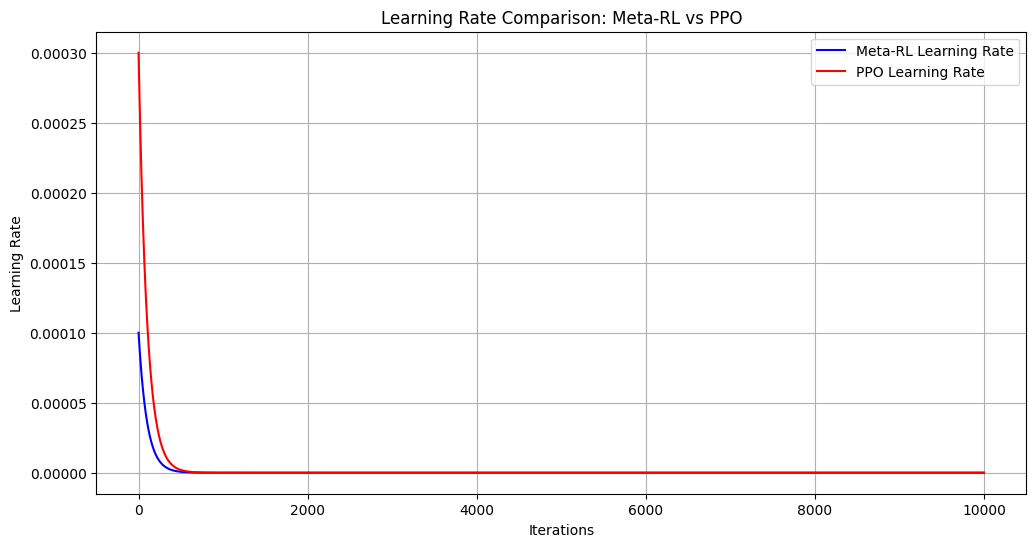

In [ ]:
# 比较 Meta-RL 和 PPO 的学习率变化
def plot_learning_rate_comparison(meta_rl_optimizer, ppo_optimizer, num_iterations=10000):
    meta_rl_lr = []
    ppo_lr = []

    # 获取 Meta-RL 和 PPO 的学习率变化
    for iteration in range(num_iterations):
        # 假设这里每一轮训练都会更新学习率
        for param_group in meta_rl_optimizer.param_groups:
            meta_rl_lr.append(param_group['lr'])
        
        for param_group in ppo_optimizer.param_groups:
            ppo_lr.append(param_group['lr'])

        # 动态衰减学习率
        for param_group in meta_rl_optimizer.param_groups:
            param_group['lr'] *= 0.99  # 每次训练迭代时，Meta-RL的学习率减小 1%

        for param_group in ppo_optimizer.param_groups:
            param_group['lr'] *= 0.99  # 每次训练迭代时，PPO的学习率减小 1%

    # 绘制学习率变化曲线
    plt.figure(figsize=(12, 6))
    plt.plot(meta_rl_lr, label="Meta-RL Learning Rate", color='b')
    plt.plot(ppo_lr, label="PPO Learning Rate", color='r')
    plt.xlabel("Iterations")
    plt.ylabel("Learning Rate")
    plt.legend()
    plt.title("Learning Rate Comparison: Meta-RL vs PPO")
    plt.grid(True)
    plt.show()

# 假设我们已经有了 Meta-RL 和 PPO 的优化器
# 需要将这段代码放在训练之后来绘制学习率变化图
plot_learning_rate_comparison(meta_rl_optimizer, ppo_optimizer, num_iterations=10000)